# Исследование предрасположенности к диабету
### Даное исследование провела студентка группы Б06-903 Рыбкина Елизавета

Импортируем необходимые библиотеки и загрузим предоставленные наборы данных:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import scipy.stats as sts
plt.style.use('ggplot')    # стиль графиков

Данные взяты с сайта kaggle. https://www.kaggle.com/pritsheta/diabetes-dataset?select=diabetes.csv

In [3]:
path = 'diabetes.csv'
data = pd.read_csv('diabetes.csv')

Данные представляют из себя 7 признаков: беременность, глюкоза, давление, толщина кожи, инсулин, ИМТ, наследственность, возраст и целевую переменную Outcome(есть ли у человека сахарный диабет).
Поставим себе задачу машинного обучения: разобьем датасет на 2 части, и будем прогнозировать значение переменной Outcome.

Выведем таблицу с данными и ее размер.

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.shape

(768, 9)

Теперь помотрим на пропуски и выбросы в датасете.

In [6]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Пропусков нет, работаем дальше

Проиллюстрируем датасет в виде гистограмм.

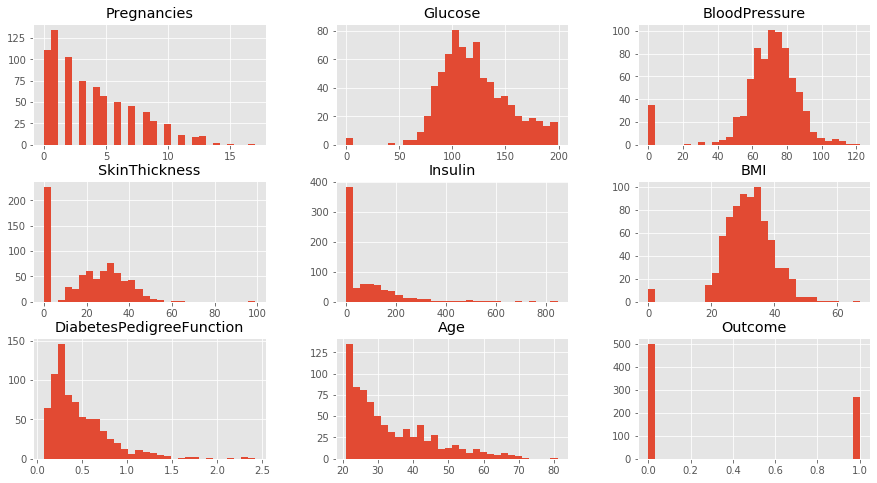

In [7]:
data[data.columns].hist(bins=30, figsize=(15, 8));

По гистограммам можно сделать несколько полезных выводов:
* Признаки Glucose, BloodPressure, BMI имеют распределение, близкое к нормальному.
* В столбцах Glucose, BloodPressure, SkinThickness, Insulin, BMI есть нулевые значения, это скорее всего соответсвует людям, для которых соответсвующий признак не измерялся (далее описан метод борьбы с данной проблемой). 
* Столбцы DiabetsPedigreeFunction, Age, Insulin имеют блинные хвосты. Попробуем взять логарифм для того, чтобы они стали нормально распределенными.

Получим средние значения и стандартное отклонение по всем признакам.

In [8]:
print('Mean Insulin in data: ' ,data['Insulin'].mean())
print('Std Insulin in data: ', data['Insulin'].std())

Mean Insulin in data:  79.79947916666667
Std Insulin in data:  115.24400235133837


Теперь получим реальные средние значения и стандартное отклонение по всем признакам (т.е. при вычислении будем игнорировать нулевые значения).

In [9]:
print('Real mean Insulin', data[data['Insulin'] > 0]['Insulin'].mean())
print('Real std Insulin', data[data['Insulin'] > 0]['Insulin'].std())

Real mean Insulin 155.5482233502538
Real std Insulin 118.77585518724514


Теперь построим $log$ диаграму (берем $log(1+x)$ чтобы при $x=0$ значение лежало в $R$). Это делается для тех признаков, у которых в обычной диаграмме наблюдается "длинный хвост".

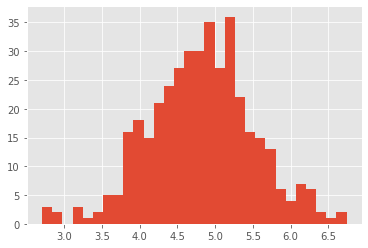

In [10]:
data[data['Insulin'] > 0]['Insulin'].apply(lambda x: np.log(1 + x)).hist(bins=30);

Видим, что данный признак (без учета нулевых значений) имеет распределение, близкое к нормальному. А значит мы подобрали верный способ, чтобы приблизить распределение к требуемому виду.

У нас слишком мало данных, чтобы выбрасывать строки, в которых значение Insulin = 0, поэтому заполним пропуски иначе: как видно на гистограмме выше, логарифм от Insulin имеет распределение, близкое к нормальному, поэтому сгенерируем новый признак, а затем сгенерируем выборку из такого распределения и заполним сгенерированными значениями некорректные значения.

In [11]:
data['LogInsulin'] = np.log(1 + data['Insulin'])
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin
0,6,148,72,35,0,33.6,0.627,50,1,0.000000
1,1,85,66,29,0,26.6,0.351,31,0,0.000000
2,8,183,64,0,0,23.3,0.672,32,1,0.000000
3,1,89,66,23,94,28.1,0.167,21,0,4.553877
4,0,137,40,35,168,43.1,2.288,33,1,5.129899


In [12]:
log_mean = data[data['LogInsulin'] > 0]['LogInsulin'].mean()
log_std = data[data['LogInsulin'] > 0]['LogInsulin'].std()

In [13]:
norm_rv = sts.norm(loc=log_mean, scale=log_std)

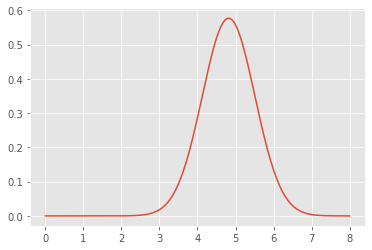

In [14]:
x = np.linspace(0, 8, 200)
plt.plot(x, norm_rv.pdf(x));

Так выглядит плотность распределения логарифма инсулина.

Создадим функцию, которая будет заполнять некорректные значения значениями нормального распределения:

In [15]:
def f(x):
  if x == 0:
    return norm_rv.rvs(1)[0]
  else:
    return x

In [16]:
data['LogInsulin'] = data['LogInsulin'].apply(f)

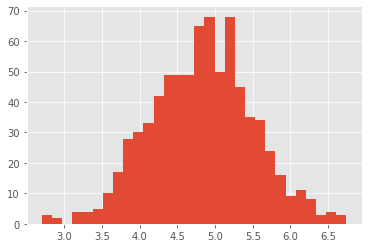

In [17]:
data['LogInsulin'].hist(bins=30);

Мы добились, чего хотели: теперь у нас есть признак, распределенный нормально, к тому же без незаполненных значений.

Напишем функцию для создания новых признаков, которые будут удовлетворять требуемым условиям.

In [18]:
def create_new_feature(data, feature, new_feature_name, log=True):
  if log:
    data[new_feature_name] = np.log(1 + data[feature])
    mean = data[data[new_feature_name] > 0][new_feature_name].mean()
    std = data[data[new_feature_name] > 0][new_feature_name].std()
    rv = sts.norm(mean, std)
    def g(x):
      if x == 0:
        return rv.rvs(1)[0]
      else:
        return x
    data[new_feature_name] = data[new_feature_name].apply(g)
  else:
    data[new_feature_name] = data[feature]
    mean = data[data[new_feature_name] > 0][new_feature_name].mean()
    std = data[data[new_feature_name] > 0][new_feature_name].std()
    rv = sts.norm(mean, std)
    def g(x):
      if x == 0:
        return rv.rvs(1)[0]
      else:
        return x
    data[new_feature_name] = data[new_feature_name].apply(g)   

In [19]:
create_new_feature(data, 'SkinThickness', 'LogSkinThickness', log=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness
0,6,148,72,35,0,33.6,0.627,50,1,3.798770,3.583519
1,1,85,66,29,0,26.6,0.351,31,0,5.171841,3.401197
2,8,183,64,0,0,23.3,0.672,32,1,4.375165,3.520275
3,1,89,66,23,94,28.1,0.167,21,0,4.553877,3.178054
4,0,137,40,35,168,43.1,2.288,33,1,5.129899,3.583519


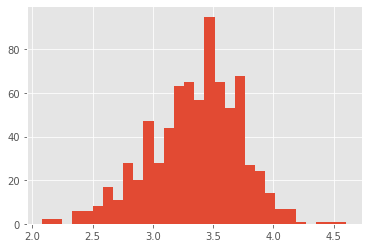

In [20]:
data['LogSkinThickness'].hist(bins=30);

In [21]:
create_new_feature(data, 'Glucose', 'LogGlucose', log=False)
create_new_feature(data, 'BloodPressure', 'LogBloodPressure', log=False)
create_new_feature(data, 'BMI', 'LogBMI', log=False)

In [22]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness,LogGlucose,LogBloodPressure,LogBMI
0,6,148,72,35,0,33.6,0.627,50,1,3.798770,3.583519,148.0,72.0,33.6
1,1,85,66,29,0,26.6,0.351,31,0,5.171841,3.401197,85.0,66.0,26.6
2,8,183,64,0,0,23.3,0.672,32,1,4.375165,3.520275,183.0,64.0,23.3
3,1,89,66,23,94,28.1,0.167,21,0,4.553877,3.178054,89.0,66.0,28.1
4,0,137,40,35,168,43.1,2.288,33,1,5.129899,3.583519,137.0,40.0,43.1


In [23]:
data.drop(columns=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], axis=1, inplace=True)
data.head()

,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,LogInsulin,LogSkinThickness,LogGlucose,LogBloodPressure,LogBMI
0,6,0.627,50,1,3.798770,3.583519,148.0,72.0,33.6
1,1,0.351,31,0,5.171841,3.401197,85.0,66.0,26.6
2,8,0.672,32,1,4.375165,3.520275,183.0,64.0,23.3
3,1,0.167,21,0,4.553877,3.178054,89.0,66.0,28.1
4,0,2.288,33,1,5.129899,3.583519,137.0,40.0,43.1


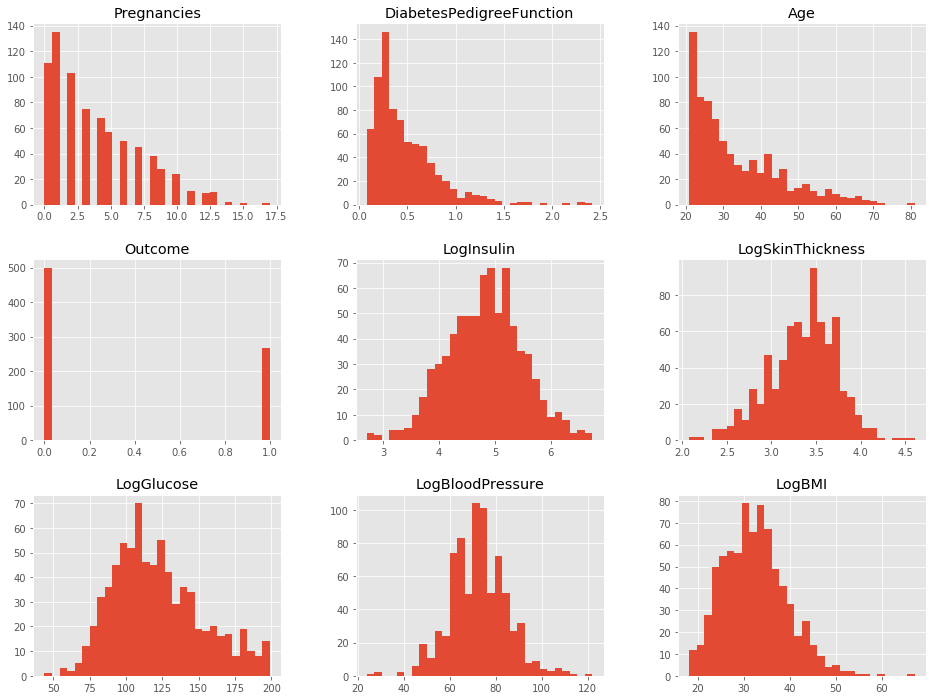

In [24]:
data[data.columns].hist(bins=30, figsize=(16, 12));

Отлично! Мы поправили почти все, что хотели, осталось лишь прологарифмировать DiabetesPedigreeFunction, т.к. в распределении этого признака слишком большой хвост.

In [25]:
data['LogDiabetesPedigreeFunction'] = data['DiabetesPedigreeFunction'].apply(lambda x: np.log(1 + x))

In [26]:
data.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

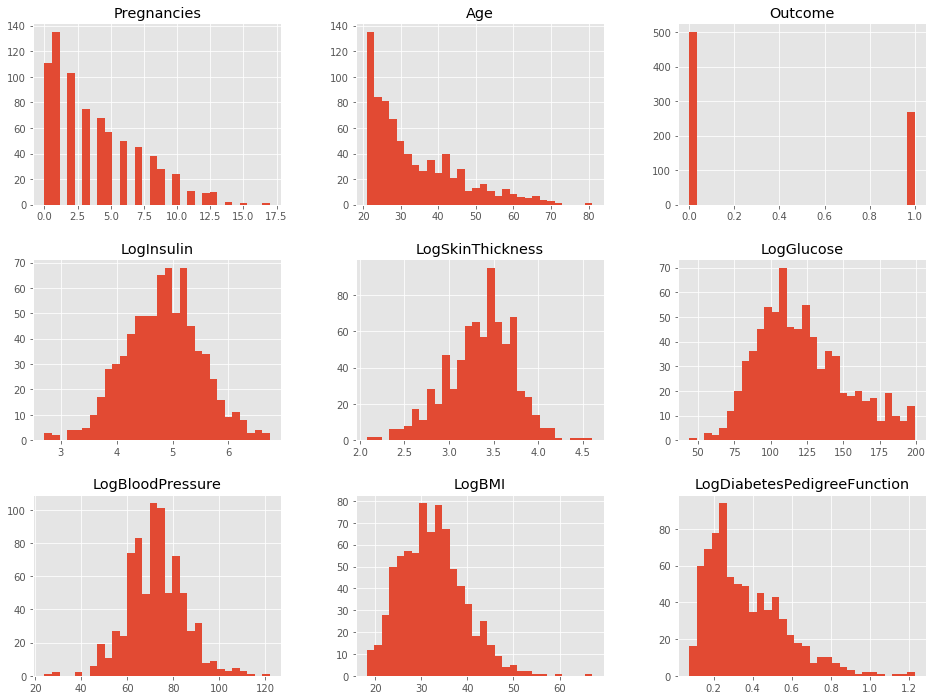

In [27]:
data[data.columns].hist(bins=30, figsize=(16, 12));

Теперь данные готовы к дальнейшей работе с ними.

Построим диаграмму корреляции:

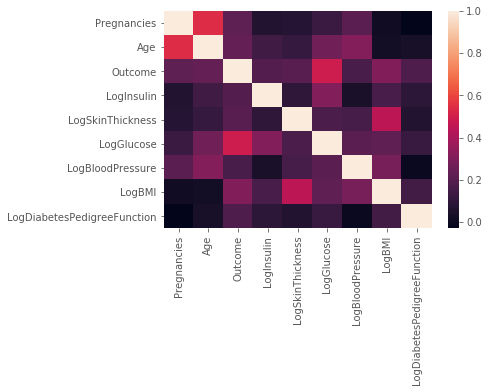

In [28]:
sns.heatmap(data.corr());

Видим, что Outcome (флаг наличия диабета) сильнее всего коррелирует с LogGlucose, что довольно логично (так как показатель инсулина явным образом влияет на диабет).

Далее построим графики зависимостей признаков друг от друга.

C:\Users\111\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\111\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


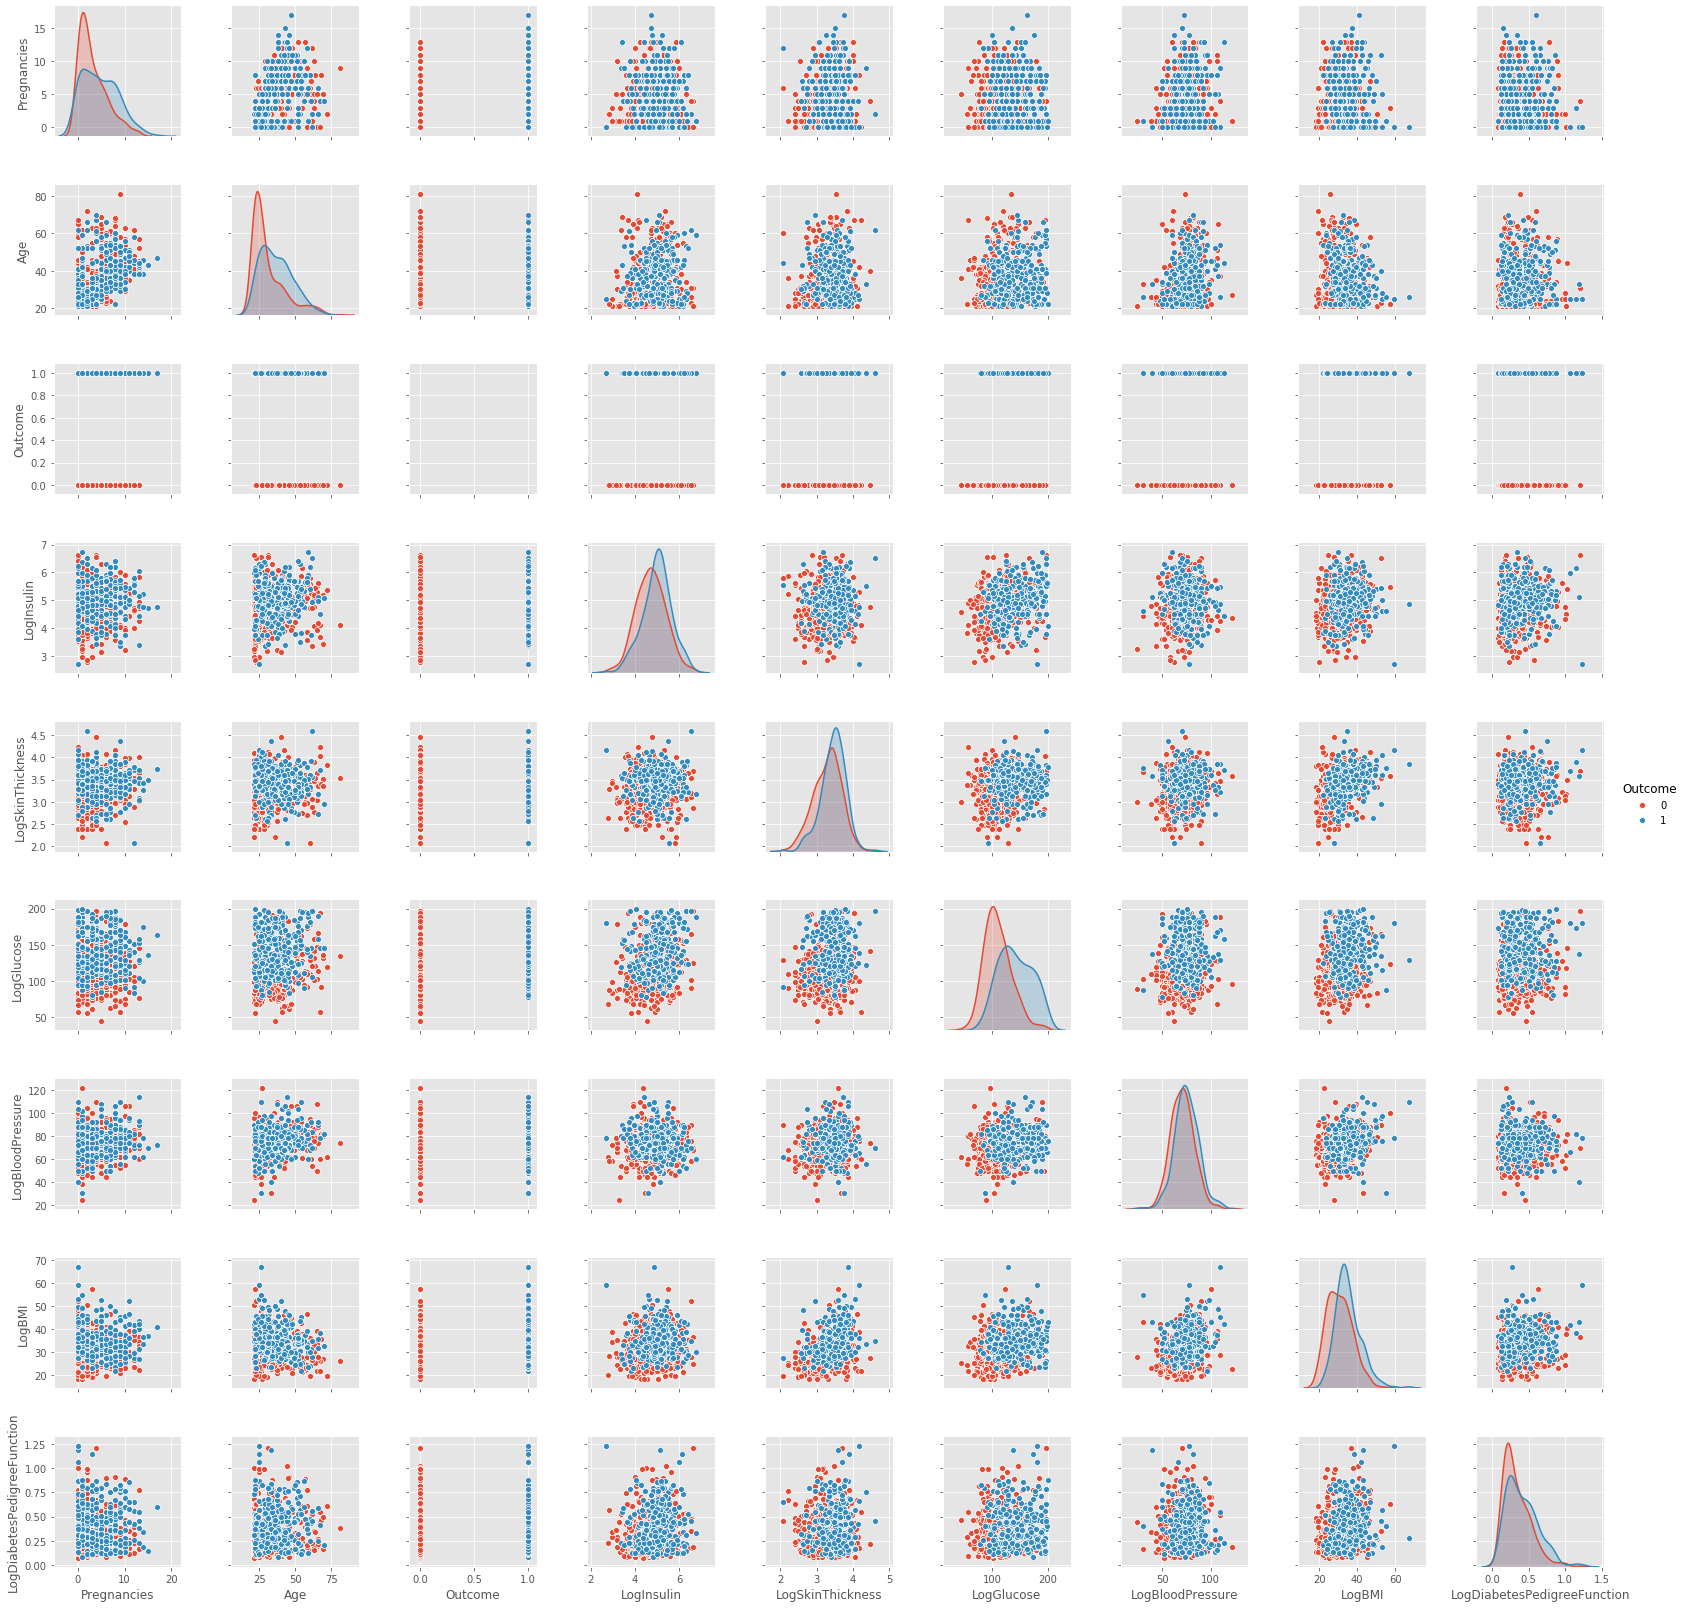

In [67]:
sns.pairplot(data, hue='Outcome');

Интересно посмотреть на графики, по оси абсцисс у которых отложено значение Glucose. Хорошо видно, что точки со значением Outcome = 1 сдвинуты вправо, то есть эти люди имеют относительно высокое содержание сахара в крови. То же самое можно сказать и про BMI.

In [34]:
data_train = data.copy()

## Базовая линейная модель с логистической функцией потерь

Импортируем необходимые методы из библиотеки

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [36]:
target_train = data_train['Outcome']
data_train = data_train[data_train.columns.drop('Outcome')]

Разделим dataset на два блока: 80% - для обучения (тренировка), 20% -для проверки (тест).

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data_train, target_train, train_size=0.8)

In [38]:
scaler = StandardScaler()

In [39]:
scaler.fit_transform(X_train)
scaler.transform(X_test);

In [40]:
from sklearn.linear_model import LogisticRegression

Подберем лучшие гиперпараметры для модели:

In [41]:
model = LogisticRegression(solver='liblinear')
clf = GridSearchCV(estimator = LogisticRegression(solver='liblinear'),
                   param_grid={'penalty': ['l1', 'l2'],
                               'C': [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 5, 10],
                               'max_iter': [70, 100, 150, 200, 300]},
                   cv=4, error_score = 'roc_auc')

In [42]:
clf.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='roc_auc',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 5, 10],
                         'max_iter': [70, 100, 150, 200, 300],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Выведем значения наилучших параметров.

In [44]:
clf.best_params_

{'C': 10, 'max_iter': 70, 'penalty': 'l1'}

In [45]:
y_pred = clf.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score, roc_auc_score

Напишем функцию, которая будет показывать точность моделей.

In [47]:
def results(y, pred):
    print('Accuracy: ', accuracy_score(y, pred))
    print('Roc_Auc: ', roc_auc_score(y, pred))

Точность модели:

In [48]:
results(y_test, y_pred)

Accuracy:  0.7272727272727273
Roc_Auc:  0.6593946540880503


## Модель решающих деревьев

In [50]:
from sklearn.tree import DecisionTreeClassifier

Подберем лучшие гиперпараметры для модели:

In [53]:
model_tree = DecisionTreeClassifier()
clf_tree = GridSearchCV(estimator=model_tree,
                        param_grid = {'max_depth': range(1, 11),
                                      'max_features': ['sqrt', 'log2'],
                                      'min_samples_leaf': range(1, 10)},
                        cv = 3,
                        n_jobs=-1)

In [54]:
clf_tree.fit(X_train, y_train)

C:\Users\111\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': ['sqrt', 'log2'],
                         'm

Выведем значения наилучших параметров.

In [56]:
clf_tree.best_params_

{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8}

In [57]:
y_pred = clf_tree.predict(X_test)

Точность модели:

In [58]:
results(y_test, y_pred)

Accuracy:  0.6753246753246753
Roc_Auc:  0.6273584905660379


Можно сделать вывод: решающее дерево с задачей справилось хуже.

## Модель случайного леса

In [59]:
from sklearn.ensemble import RandomForestClassifier

Подберем лучшие гиперпараметры для модели:

In [60]:
model_forest = RandomForestClassifier(n_estimators=350)
clf_forest = GridSearchCV(estimator=model_forest,
                          param_grid={'max_features': ['sqrt', 'log2']},
                          n_jobs=-1)

In [61]:
clf_forest.fit(X_train, y_train)

C:\Users\111\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=350, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             i

In [64]:
clf_forest.best_params_

{'max_features': 'log2'}

In [65]:
y_pred = clf_forest.predict(X_test)

Точность модели:

In [66]:
results(y_test, y_pred)

Accuracy:  0.7272727272727273
Roc_Auc:  0.6707940251572329


Вывод: случайный лес хорошо справился с задачей.

## Результаты
* Поставили задачу машинного обучения
* Посмотрели на данные и поняли, что в них есть существенные проблемы
* Устранили проблемы в данных и подготовили их для использования алгоритмами машинного обучения
* Обучили несколько моделей и сравнили их качетсво. Логистическая регрессия справилась с задачей лучше всего.